<a href="https://colab.research.google.com/github/vishva2410/Deep-Learning-Projects-Part-A-/blob/main/expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install gradio

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from glob import glob
from zipfile import ZipFile
import os
import cv2
from PIL import Image
import gradio as gr
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from google.colab import files
import tensorflow as tf
from google.colab import drive
from IPython import get_ipython
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [16]:
get_ipython().magic('reset -sf')

In [ ]:
with ZipFile('face_recog.zip', 'r') as zipObj:
   zipObj.extractall()

In [34]:
path_train = '/content/face_recog/train'
path_test = '/content/face_recog/test'

classes = os.listdir(path_train)
classes

['surprise', 'fear', 'neutral', 'happy', 'sad', 'disgust', 'angry']

In [35]:
for cat in classes:
  print(f'Class {cat} size: {len(os.listdir(path_train + "/" + cat))}')

Class surprise size: 3171
Class fear size: 4097
Class neutral size: 4965
Class happy size: 7215
Class sad size: 4830
Class disgust size: 436
Class angry size: 3995


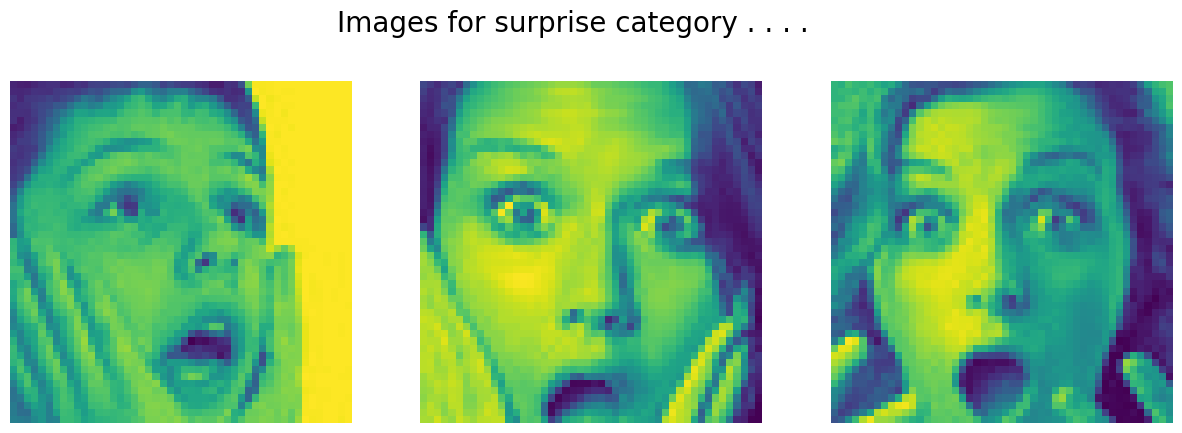

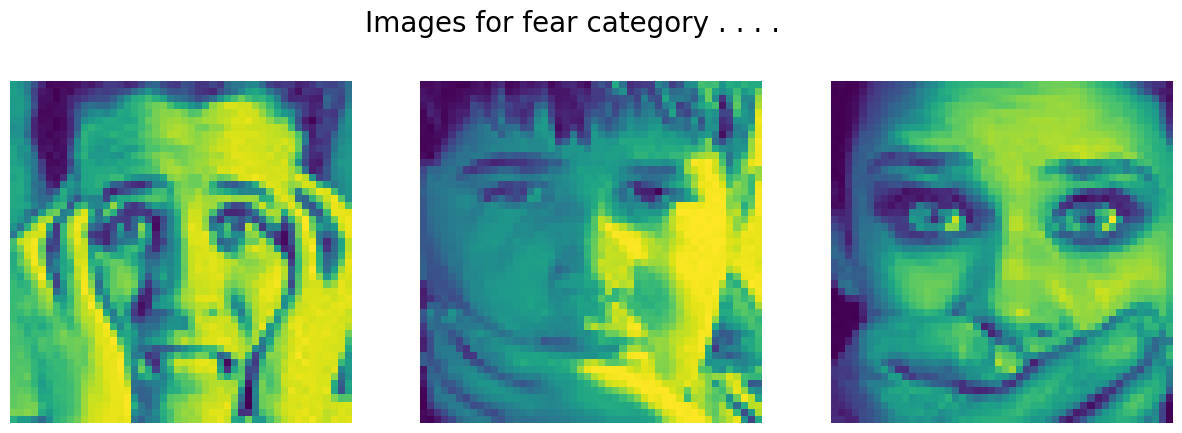

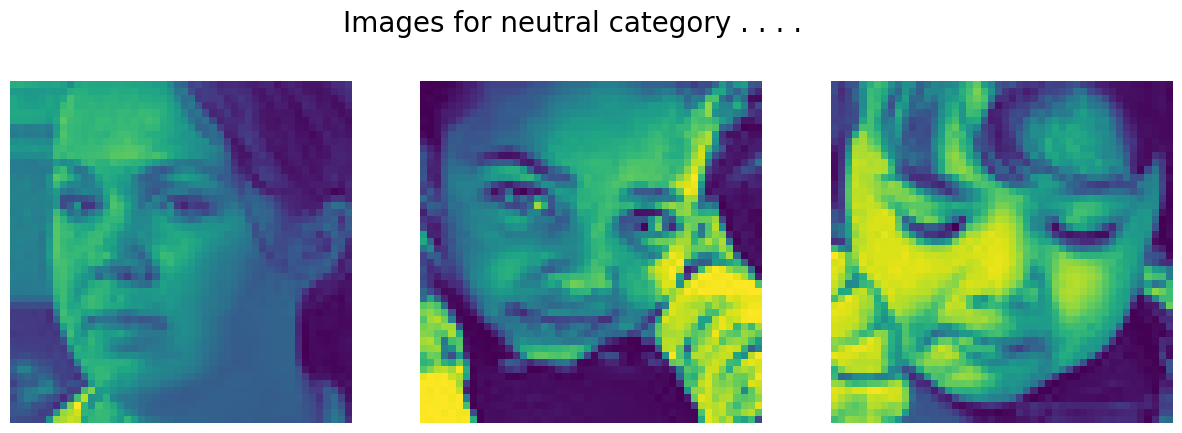

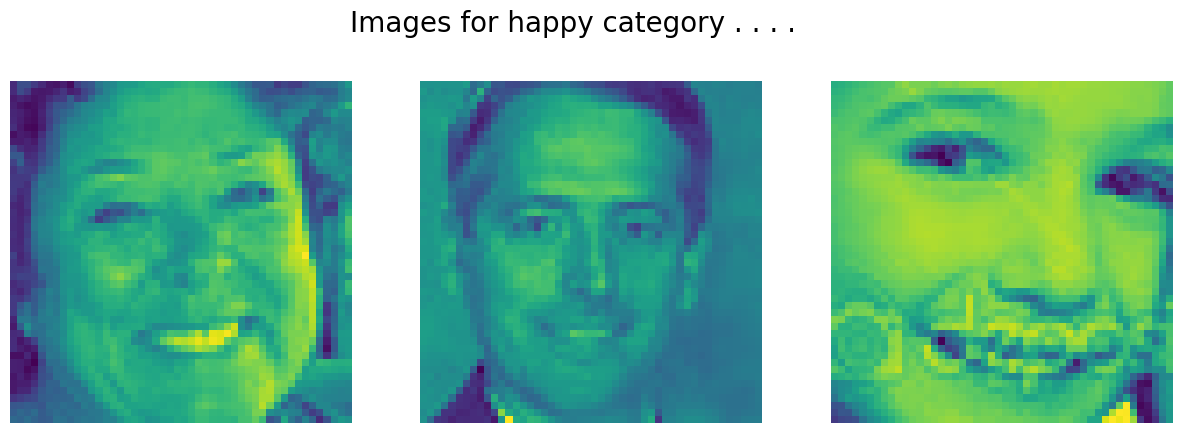

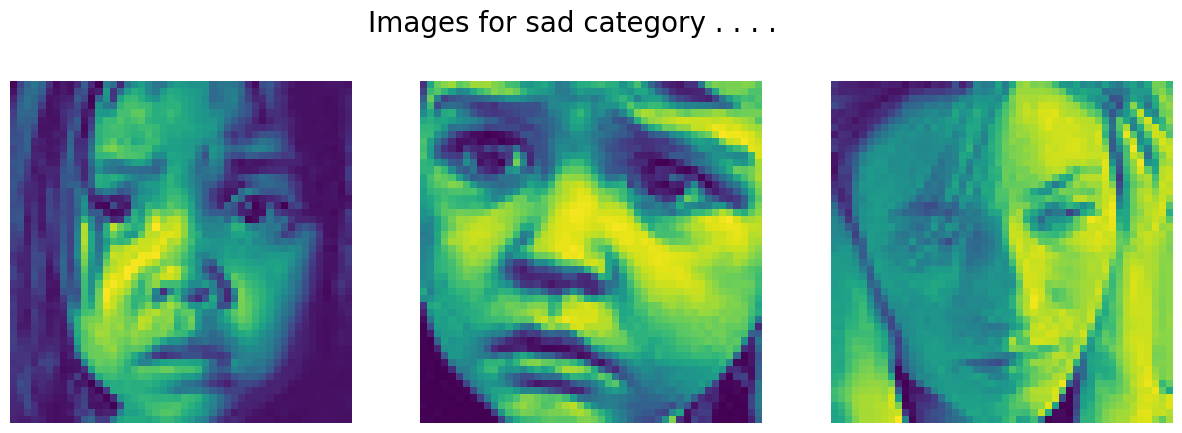

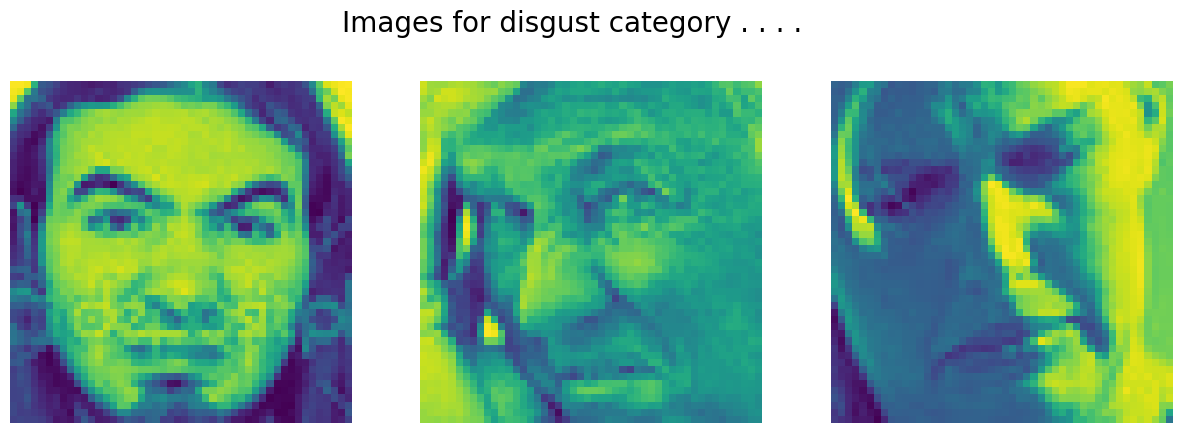

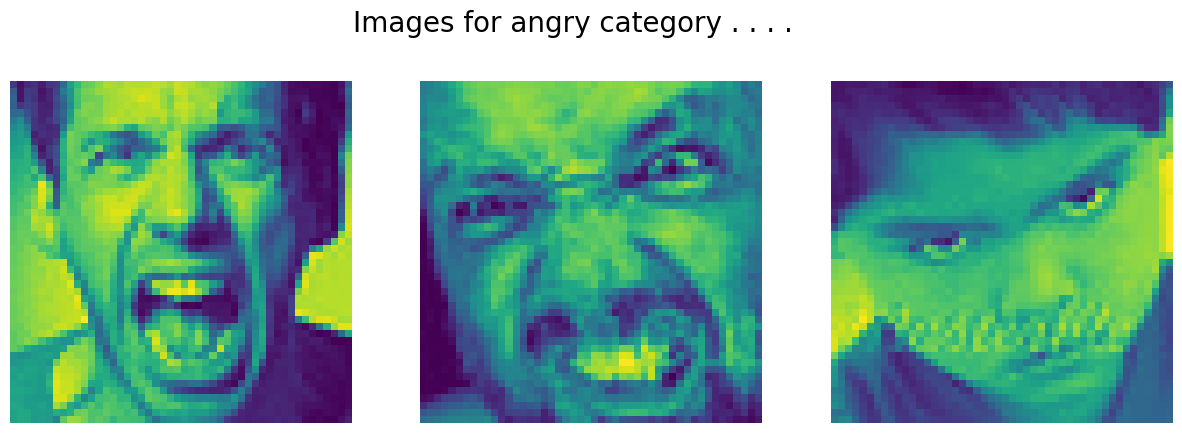

In [36]:
for cat in classes:
  image_dir = f'{path_train}/{cat}'
  images = os.listdir(image_dir)
  images = [img for img in images if os.path.isfile(os.path.join(image_dir, img))]
  fig, ax = plt.subplots(1, 3, figsize = (15, 5))
  fig.suptitle(f'Images for {cat} category . . . .',
                 fontsize = 20)

  for i in range(3):
      if images:
          k = np.random.randint(0, len(images))
          img = np.array(Image.open(f'{path_train}/{cat}/{images[k]}'))
          ax[i].imshow(img)
          ax[i].axis('off')
      else:
            print(f"No images found in directory: {image_dir}")
  plt.show()

In [22]:
train_folder = ['/content/face_recog/train/angry','/content/face_recog/train/disgust','/content/face_recog/train/fear','/content/face_recog/train/happy','/content/face_recog/train/neutral','/content/face_recog/train/sad','/content/face_recog/train/surprise']
test_folder = ['/content/face_recog/test/angry','/content/face_recog/test/disgust','/content/face_recog/test/fear','/content/face_recog/test/happy','/content/face_recog/test/neutral','/content/face_recog/test/sad','/content/face_recog/test/surprise']

IMG_SIZE = 224
BATCH_SIZE = 32

X_train,Y_train = [],[]
X_test,Y_test = [],[]


In [23]:
for i,train_path in enumerate(train_folder):
  images = glob(f'{train_path}/*.*')
  print(f"Found {len(images)} images in {train_path}")

  for img in images:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    X_train.append(img)
    Y_train.append(i)

Found 3995 images in /content/face_recog/train/angry
Found 436 images in /content/face_recog/train/disgust
Found 4097 images in /content/face_recog/train/fear
Found 7215 images in /content/face_recog/train/happy
Found 4965 images in /content/face_recog/train/neutral
Found 4830 images in /content/face_recog/train/sad
Found 3171 images in /content/face_recog/train/surprise


In [24]:
for i,test_path in enumerate(test_folder):
  images = glob(f'{test_path}/*.*')
  print(f"Found {len(images)} images in {test_path}")

  for img in images:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    X_test.append(img)
    Y_test.append(i)

Found 958 images in /content/face_recog/test/angry
Found 111 images in /content/face_recog/test/disgust
Found 1024 images in /content/face_recog/test/fear
Found 1774 images in /content/face_recog/test/happy
Found 1233 images in /content/face_recog/test/neutral
Found 1247 images in /content/face_recog/test/sad
Found 831 images in /content/face_recog/test/surprise


In [13]:
X_train = np.array(X_train, dtype=np.uint8)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [37]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(
    '/content/face_recog/train',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/content/face_recog/test',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 25841 images belonging to 7 classes.
Found 715 images belonging to 7 classes.


In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')  # 7 classes for emotion
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,578,311 (128.09 MB)

 Trainable params: 33,578,119 (128.09 MB)

 Non-trainable params: 192 (768.00 B)

In [42]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # 7 classes for emotion

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,576,903 (13.64 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [43]:
model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 332s 202ms/step - accuracy: 0.3947 - loss: 1.6421 - val_accuracy: 0.4699 - val_loss: 1.4089
Epoch 2/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 323s 200ms/step - accuracy: 0.4829 - loss: 1.3493 - val_accuracy: 0.4713 - val_loss: 1.3495
Epoch 3/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 322s 199ms/step - accuracy: 0.5069 - loss: 1.2835 - val_accuracy: 0.4727 - val_loss: 1.3715
Epoch 4/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 323s 200ms/step - accuracy: 0.5393 - loss: 1.2081 - val_accuracy: 0.5007 - val_loss: 1.3326
Epoch 5/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 326s 202ms/step - accuracy: 0.5668 - loss: 1.1372 - val_accuracy: 0.4825 - val_loss: 1.4119
Epoch 6/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 324s 200ms/step - accuracy: 0.5976 - loss: 1.0641 - val_accuracy: 0.5133 - val_loss: 1.3727
Epoch 7/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 322s 199ms/step - accuracy: 0.6236 - loss: 0.9941 - val_accuracy: 0.5007 - val_loss: 1.3841
Epoch 8/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 326s 201ms/step - ac

In [44]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

ValueError: Layer "functional_3" expects 1 input(s), but it received 7178 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_8:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_9:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_10:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_11:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_12:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_13:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_14:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_15:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_16:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_17:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_18:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_19:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_20:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_21:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_22:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_23:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_24:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_25:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_26:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_27:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_28:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_29:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_30:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_31:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_32:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_33:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_34:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_35:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_36:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_37:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_38:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_39:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_40:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_41:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_42:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_43:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_44:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_45:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_46:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_47:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_48:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_49:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_50:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_51:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_52:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_53:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_54:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_55:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_56:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_57:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_58:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_59:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_60:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_61:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_62:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_63:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_64:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_65:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_66:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_67:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_68:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_69:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_70:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_71:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_72:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_73:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_74:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_75:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_76:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_77:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_78:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_79:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_80:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_81:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_82:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_83:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_84:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_85:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_86:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_87:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_88:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_89:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_90:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_91:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_92:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_93:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_94:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_95:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_96:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_97:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_98:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_99:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_100:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_101:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_102:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_103:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_104:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_105:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_106:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_107:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_108:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_109:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_110:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_111:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_112:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_113:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_114:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_115:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_116:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_117:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_118:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_119:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_120:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_121:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_122:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_123:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_124:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_125:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_126:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_127:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_128:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_129:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_130:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_131:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_132:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_133:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_134:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_135:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_136:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_137:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_138:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_139:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_140:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_141:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_142:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_143:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_144:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_145:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_146:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_147:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_148:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_149:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_150:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_151:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_152:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_153:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_154:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_155:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_156:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_157:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_158:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_159:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_160:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_161:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_162:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_163:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_164:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_165:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_166:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_167:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_168:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_169:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_170:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_171:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_172:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_173:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_174:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_175:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_176:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_177:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_178:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_179:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_180:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_181:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_182:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_183:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_184:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_185:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_186:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_187:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_188:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_189:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_190:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_191:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_192:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_193:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_194:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_195:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_196:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_197:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_198:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_199:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_200:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_201:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_202:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_203:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_204:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_205:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_206:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_207:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_208:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_209:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_210:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_211:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_212:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_213:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_214:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_215:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_216:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_217:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_218:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_219:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_220:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_221:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_222:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_223:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_224:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_225:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_226:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_227:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_228:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_229:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_230:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_231:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_232:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_233:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_234:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_235:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_236:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_237:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_238:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_239:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_240:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_241:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_242:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_243:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_244:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_245:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_246:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_247:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_248:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_249:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_250:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_251:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_252:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_253:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_254:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_255:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_256:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_257:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_258:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_259:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_260:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_261:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_262:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_263:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_264:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_265:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_266:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_267:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_268:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_269:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_270:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_271:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_272:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_273:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_274:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_275:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_276:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_277:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_278:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_279:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_280:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_281:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_282:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_283:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_284:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_285:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_286:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_287:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_288:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_289:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_290:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_291:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_292:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_293:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_294:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_295:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_296:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_297:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_298:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_299:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_300:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_301:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_302:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_303:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_304:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_305:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_306:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_307:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_308:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_309:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_310:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_311:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_312:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_313:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_314:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_315:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_316:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_317:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_318:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_319:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_320:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_321:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_322:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_323:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_324:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_325:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_326:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_327:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_328:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_329:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_330:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_331:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_332:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_333:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_334:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_335:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_336:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_337:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_338:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_339:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_340:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_341:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_342:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_343:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_344:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_345:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_346:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_347:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_348:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_349:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_350:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_351:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_352:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_353:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_354:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_355:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_356:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_357:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_358:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_359:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_360:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_361:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_362:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_363:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_364:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_365:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_366:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_367:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_368:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_369:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_370:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_371:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_372:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_373:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_374:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_375:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_376:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_377:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_378:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_379:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_380:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_381:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_382:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_383:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_384:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_385:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_386:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_387:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_388:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_389:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_390:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_391:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_392:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_393:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_394:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_395:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_396:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_397:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_398:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_399:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_400:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_401:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_402:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_403:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_404:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_405:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_406:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_407:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_408:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_409:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_410:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_411:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_412:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_413:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_414:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_415:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_416:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_417:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_418:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_419:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_420:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_421:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_422:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_423:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_424:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_425:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_426:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_427:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_428:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_429:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_430:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_431:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_432:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_433:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_434:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_435:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_436:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_437:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_438:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_439:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_440:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_441:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_442:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_443:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_444:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_445:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_446:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_447:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_448:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_449:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_450:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_451:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_452:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_453:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_454:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_455:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_456:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_457:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_458:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_459:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_460:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_461:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_462:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_463:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_464:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_465:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_466:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_467:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_468:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_469:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_470:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_471:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_472:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_473:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_474:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_475:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_476:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_477:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_478:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_479:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_480:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_481:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_482:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_483:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_484:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_485:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_486:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_487:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_488:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_489:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_490:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_491:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_492:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_493:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_494:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_495:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_496:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_497:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_498:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_499:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_500:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_501:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_502:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_503:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_504:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_505:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_506:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_507:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_508:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_509:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_510:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_511:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_512:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_513:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_514:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_515:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_516:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_517:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_518:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_519:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_520:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_521:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_522:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_523:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_524:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_525:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_526:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_527:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_528:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_529:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_530:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_531:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_532:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_533:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_534:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_535:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_536:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_537:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_538:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_539:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_540:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_541:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_542:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_543:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_544:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_545:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_546:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_547:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_548:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_549:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_550:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_551:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_552:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_553:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_554:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_555:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_556:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_557:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_558:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_559:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_560:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_561:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_562:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_563:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_564:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_565:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_566:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_567:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_568:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_569:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_570:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_571:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_572:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_573:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_574:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_575:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_576:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_577:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_578:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_579:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_580:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_581:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_582:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_583:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_584:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_585:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_586:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_587:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_588:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_589:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_590:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_591:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_592:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_593:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_594:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_595:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_596:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_597:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_598:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_599:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_600:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_601:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_602:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_603:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_604:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_605:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_606:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_607:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_608:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_609:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_610:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_611:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_612:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_613:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_614:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_615:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_616:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_617:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_618:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_619:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_620:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_621:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_622:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_623:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_624:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_625:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_626:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_627:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_628:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_629:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_630:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_631:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_632:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_633:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_634:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_635:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_636:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_637:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_638:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_639:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_640:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_641:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_642:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_643:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_644:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_645:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_646:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_647:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_648:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_649:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_650:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_651:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_652:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_653:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_654:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_655:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_656:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_657:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_658:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_659:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_660:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_661:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_662:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_663:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_664:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_665:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_666:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_667:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_668:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_669:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_670:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_671:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_672:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_673:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_674:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_675:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_676:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_677:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_678:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_679:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_680:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_681:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_682:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_683:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_684:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_685:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_686:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_687:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_688:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_689:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_690:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_691:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_692:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_693:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_694:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_695:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_696:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_697:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_698:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_699:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_700:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_701:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_702:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_703:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_704:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_705:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_706:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_707:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_708:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_709:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_710:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_711:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_712:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_713:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_714:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_715:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_716:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_717:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_718:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_719:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_720:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_721:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_722:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_723:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_724:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_725:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_726:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_727:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_728:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_729:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_730:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_731:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_732:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_733:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_734:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_735:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_736:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_737:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_738:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_739:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_740:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_741:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_742:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_743:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_744:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_745:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_746:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_747:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_748:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_749:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_750:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_751:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_752:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_753:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_754:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_755:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_756:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_757:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_758:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_759:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_760:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_761:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_762:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_763:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_764:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_765:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_766:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_767:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_768:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_769:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_770:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_771:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_772:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_773:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_774:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_775:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_776:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_777:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_778:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_779:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_780:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_781:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_782:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_783:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_784:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_785:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_786:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_787:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_788:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_789:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_790:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_791:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_792:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_793:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_794:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_795:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_796:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_797:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_798:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_799:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_800:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_801:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_802:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_803:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_804:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_805:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_806:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_807:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_808:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_809:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_810:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_811:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_812:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_813:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_814:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_815:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_816:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_817:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_818:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_819:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_820:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_821:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_822:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_823:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_824:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_825:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_826:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_827:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_828:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_829:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_830:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_831:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_832:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_833:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_834:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_835:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_836:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_837:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_838:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_839:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_840:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_841:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_842:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_843:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_844:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_845:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_846:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_847:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_848:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_849:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_850:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_851:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_852:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_853:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_854:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_855:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_856:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_857:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_858:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_859:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_860:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_861:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_862:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_863:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_864:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_865:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_866:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_867:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_868:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_869:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_870:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_871:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_872:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_873:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_874:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_875:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_876:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_877:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_878:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_879:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_880:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_881:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_882:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_883:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_884:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_885:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_886:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_887:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_888:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_889:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_890:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_891:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_892:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_893:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_894:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_895:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_896:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_897:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_898:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_899:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_900:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_901:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_902:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_903:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_904:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_905:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_906:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_907:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_908:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_909:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_910:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_911:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_912:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_913:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_914:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_915:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_916:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_917:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_918:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_919:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_920:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_921:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_922:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_923:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_924:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_925:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_926:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_927:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_928:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_929:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_930:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_931:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_932:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_933:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_934:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_935:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_936:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_937:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_938:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_939:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_940:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_941:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_942:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_943:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_944:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_945:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_946:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_947:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_948:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_949:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_950:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_951:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_952:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_953:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_954:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_955:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_956:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_957:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_958:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_959:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_960:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_961:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_962:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_963:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_964:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_965:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_966:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_967:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_968:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_969:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_970:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_971:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_972:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_973:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_974:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_975:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_976:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_977:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_978:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_979:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_980:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_981:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_982:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_983:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_984:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_985:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_986:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_987:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_988:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_989:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_990:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_991:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_992:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_993:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_994:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_995:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_996:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_997:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_998:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_999:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1000:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1001:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1002:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1003:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1004:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1005:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1006:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1007:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1008:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1009:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1010:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1011:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1012:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1013:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1014:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1015:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1016:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1017:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1018:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1019:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1020:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1021:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1022:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1023:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1024:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1025:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1026:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1027:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1028:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1029:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1030:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1031:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1032:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1033:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1034:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1035:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1036:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1037:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1038:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1039:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1040:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1041:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1042:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1043:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1044:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1045:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1046:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1047:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1048:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1049:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1050:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1051:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1052:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1053:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1054:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1055:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1056:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1057:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1058:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1059:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1060:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1061:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1062:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1063:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1064:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1065:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1066:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1067:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1068:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1069:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1070:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1071:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1072:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1073:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1074:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1075:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1076:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1077:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1078:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1079:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1080:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1081:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1082:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1083:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1084:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1085:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1086:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1087:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1088:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1089:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1090:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1091:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1092:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1093:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1094:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1095:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1096:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1097:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1098:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1099:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1100:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1101:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1102:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1103:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1104:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1105:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1106:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1107:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1108:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1109:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1110:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1111:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1112:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1113:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1114:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1115:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1116:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1117:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1118:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1119:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1120:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1121:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1122:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1123:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1124:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1125:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1126:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1127:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1128:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1129:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1130:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1131:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1132:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1133:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1134:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1135:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1136:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1137:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1138:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1139:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1140:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1141:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1142:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1143:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1144:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1145:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1146:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1147:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1148:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1149:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1150:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1151:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1152:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1153:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1154:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1155:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1156:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1157:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1158:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1159:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1160:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1161:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1162:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1163:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1164:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1165:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1166:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1167:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1168:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1169:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1170:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1171:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1172:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1173:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1174:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1175:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1176:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1177:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1178:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1179:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1180:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1181:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1182:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1183:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1184:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1185:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1186:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1187:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1188:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1189:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1190:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1191:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1192:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1193:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1194:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1195:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1196:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1197:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1198:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1199:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1200:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1201:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1202:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1203:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1204:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1205:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1206:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1207:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1208:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1209:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1210:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1211:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1212:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1213:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1214:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1215:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1216:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1217:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1218:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1219:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1220:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1221:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1222:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1223:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1224:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1225:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1226:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1227:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1228:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1229:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1230:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1231:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1232:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1233:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1234:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1235:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1236:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1237:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1238:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1239:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1240:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1241:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1242:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1243:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1244:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1245:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1246:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1247:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1248:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1249:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1250:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1251:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1252:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1253:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1254:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1255:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1256:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1257:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1258:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1259:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1260:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1261:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1262:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1263:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1264:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1265:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1266:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1267:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1268:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1269:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1270:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1271:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1272:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1273:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1274:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1275:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1276:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1277:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1278:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1279:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1280:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1281:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1282:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1283:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1284:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1285:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1286:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1287:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1288:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1289:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1290:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1291:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1292:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1293:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1294:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1295:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1296:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1297:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1298:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1299:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1300:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1301:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1302:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1303:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1304:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1305:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1306:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1307:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1308:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1309:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1310:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1311:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1312:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1313:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1314:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1315:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1316:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1317:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1318:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1319:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1320:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1321:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1322:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1323:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1324:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1325:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1326:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1327:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1328:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1329:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1330:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1331:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1332:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1333:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1334:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1335:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1336:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1337:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1338:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1339:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1340:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1341:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1342:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1343:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1344:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1345:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1346:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1347:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1348:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1349:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1350:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1351:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1352:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1353:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1354:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1355:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1356:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1357:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1358:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1359:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1360:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1361:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1362:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1363:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1364:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1365:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1366:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1367:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1368:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1369:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1370:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1371:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1372:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1373:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1374:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1375:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1376:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1377:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1378:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1379:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1380:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1381:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1382:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1383:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1384:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1385:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1386:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1387:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1388:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1389:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1390:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1391:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1392:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1393:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1394:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1395:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1396:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1397:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1398:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1399:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1400:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1401:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1402:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1403:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1404:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1405:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1406:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1407:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1408:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1409:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1410:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1411:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1412:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1413:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1414:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1415:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1416:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1417:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1418:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1419:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1420:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1421:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1422:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1423:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1424:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1425:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1426:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1427:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1428:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1429:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1430:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1431:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1432:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1433:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1434:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1435:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1436:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1437:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1438:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1439:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1440:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1441:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1442:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1443:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1444:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1445:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1446:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1447:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1448:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1449:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1450:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1451:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1452:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1453:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1454:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1455:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1456:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1457:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1458:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1459:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1460:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1461:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1462:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1463:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1464:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1465:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1466:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1467:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1468:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1469:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1470:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1471:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1472:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1473:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1474:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1475:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1476:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1477:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1478:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1479:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1480:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1481:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1482:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1483:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1484:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1485:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1486:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1487:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1488:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1489:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1490:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1491:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1492:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1493:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1494:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1495:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1496:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1497:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1498:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1499:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1500:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1501:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1502:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1503:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1504:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1505:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1506:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1507:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1508:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1509:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1510:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1511:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1512:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1513:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1514:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1515:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1516:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1517:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1518:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1519:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1520:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1521:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1522:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1523:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1524:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1525:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1526:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1527:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1528:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1529:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1530:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1531:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1532:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1533:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1534:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1535:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1536:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1537:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1538:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1539:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1540:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1541:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1542:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1543:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1544:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1545:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1546:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1547:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1548:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1549:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1550:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1551:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1552:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1553:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1554:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1555:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1556:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1557:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1558:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1559:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1560:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1561:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1562:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1563:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1564:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1565:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1566:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1567:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1568:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1569:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1570:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1571:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1572:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1573:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1574:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1575:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1576:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1577:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1578:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1579:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1580:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1581:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1582:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1583:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1584:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1585:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1586:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1587:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1588:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1589:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1590:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1591:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1592:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1593:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1594:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1595:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1596:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1597:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1598:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1599:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1600:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1601:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1602:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1603:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1604:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1605:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1606:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1607:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1608:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1609:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1610:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1611:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1612:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1613:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1614:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1615:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1616:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1617:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1618:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1619:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1620:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1621:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1622:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1623:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1624:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1625:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1626:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1627:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1628:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1629:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1630:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1631:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1632:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1633:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1634:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1635:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1636:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1637:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1638:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1639:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1640:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1641:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1642:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1643:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1644:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1645:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1646:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1647:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1648:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1649:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1650:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1651:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1652:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1653:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1654:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1655:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1656:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1657:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1658:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1659:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1660:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1661:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1662:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1663:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1664:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1665:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1666:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1667:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1668:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1669:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1670:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1671:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1672:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1673:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1674:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1675:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1676:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1677:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1678:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1679:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1680:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1681:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1682:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1683:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1684:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1685:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1686:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1687:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1688:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1689:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1690:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1691:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1692:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1693:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1694:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1695:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1696:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1697:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1698:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1699:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1700:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1701:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1702:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1703:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1704:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1705:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1706:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1707:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1708:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1709:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1710:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1711:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1712:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1713:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1714:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1715:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1716:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1717:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1718:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1719:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1720:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1721:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1722:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1723:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1724:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1725:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1726:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1727:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1728:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1729:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1730:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1731:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1732:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1733:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1734:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1735:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1736:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1737:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1738:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1739:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1740:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1741:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1742:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1743:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1744:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1745:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1746:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1747:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1748:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1749:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1750:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1751:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1752:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1753:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1754:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1755:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1756:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1757:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1758:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1759:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1760:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1761:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1762:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1763:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1764:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1765:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1766:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1767:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1768:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1769:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1770:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1771:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1772:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1773:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1774:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1775:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1776:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1777:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1778:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1779:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1780:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1781:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1782:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1783:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1784:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1785:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1786:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1787:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1788:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1789:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1790:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1791:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1792:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1793:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1794:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1795:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1796:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1797:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1798:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1799:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1800:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1801:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1802:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1803:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1804:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1805:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1806:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1807:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1808:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1809:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1810:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1811:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1812:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1813:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1814:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1815:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1816:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1817:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1818:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1819:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1820:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1821:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1822:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1823:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1824:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1825:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1826:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1827:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1828:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1829:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1830:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1831:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1832:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1833:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1834:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1835:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1836:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1837:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1838:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1839:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1840:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1841:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1842:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1843:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1844:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1845:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1846:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1847:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1848:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1849:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1850:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1851:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1852:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1853:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1854:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1855:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1856:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1857:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1858:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1859:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1860:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1861:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1862:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1863:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1864:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1865:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1866:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1867:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1868:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1869:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1870:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1871:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1872:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1873:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1874:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1875:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1876:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1877:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1878:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1879:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1880:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1881:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1882:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1883:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1884:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1885:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1886:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1887:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1888:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1889:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1890:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1891:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1892:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1893:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1894:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1895:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1896:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1897:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1898:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1899:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1900:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1901:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1902:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1903:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1904:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1905:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1906:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1907:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1908:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1909:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1910:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1911:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1912:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1913:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1914:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1915:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1916:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1917:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1918:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1919:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1920:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1921:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1922:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1923:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1924:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1925:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1926:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1927:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1928:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1929:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1930:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1931:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1932:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1933:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1934:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1935:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1936:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1937:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1938:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1939:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1940:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1941:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1942:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1943:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1944:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1945:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1946:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1947:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1948:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1949:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1950:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1951:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1952:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1953:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1954:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1955:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1956:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1957:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1958:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1959:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1960:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1961:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1962:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1963:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1964:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1965:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1966:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1967:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1968:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1969:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1970:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1971:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1972:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1973:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1974:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1975:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1976:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1977:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1978:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1979:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1980:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1981:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1982:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1983:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1984:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1985:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1986:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1987:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1988:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1989:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1990:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1991:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1992:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1993:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1994:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1995:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1996:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1997:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1998:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_1999:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2000:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2001:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2002:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2003:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2004:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2005:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2006:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2007:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2008:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2009:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2010:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2011:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2012:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2013:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2014:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2015:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2016:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2017:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2018:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2019:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2020:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2021:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2022:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2023:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2024:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2025:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2026:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2027:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2028:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2029:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2030:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2031:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2032:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2033:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2034:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2035:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2036:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2037:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2038:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2039:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2040:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2041:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2042:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2043:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2044:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2045:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2046:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2047:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2048:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2049:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2050:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2051:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2052:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2053:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2054:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2055:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2056:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2057:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2058:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2059:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2060:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2061:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2062:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2063:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2064:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2065:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2066:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2067:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2068:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2069:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2070:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2071:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2072:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2073:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2074:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2075:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2076:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2077:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2078:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2079:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2080:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2081:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2082:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2083:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2084:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2085:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2086:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2087:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2088:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2089:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2090:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2091:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2092:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2093:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2094:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2095:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2096:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2097:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2098:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2099:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2100:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2101:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2102:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2103:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2104:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2105:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2106:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2107:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2108:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2109:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2110:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2111:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2112:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2113:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2114:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2115:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2116:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2117:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2118:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2119:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2120:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2121:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2122:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2123:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2124:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2125:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2126:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2127:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2128:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2129:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2130:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2131:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2132:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2133:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2134:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2135:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2136:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2137:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2138:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2139:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2140:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2141:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2142:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2143:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2144:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2145:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2146:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2147:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2148:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2149:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2150:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2151:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2152:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2153:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2154:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2155:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2156:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2157:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2158:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2159:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2160:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2161:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2162:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2163:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2164:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2165:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2166:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2167:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2168:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2169:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2170:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2171:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2172:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2173:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2174:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2175:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2176:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2177:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2178:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2179:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2180:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2181:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2182:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2183:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2184:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2185:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2186:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2187:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2188:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2189:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2190:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2191:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2192:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2193:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2194:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2195:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2196:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2197:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2198:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2199:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2200:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2201:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2202:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2203:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2204:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2205:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2206:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2207:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2208:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2209:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2210:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2211:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2212:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2213:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2214:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2215:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2216:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2217:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2218:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2219:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2220:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2221:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2222:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2223:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2224:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2225:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2226:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2227:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2228:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2229:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2230:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2231:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2232:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2233:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2234:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2235:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2236:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2237:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2238:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2239:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2240:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2241:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2242:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2243:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2244:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2245:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2246:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2247:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2248:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2249:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2250:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2251:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2252:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2253:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2254:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2255:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2256:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2257:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2258:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2259:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2260:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2261:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2262:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2263:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2264:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2265:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2266:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2267:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2268:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2269:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2270:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2271:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2272:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2273:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2274:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2275:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2276:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2277:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2278:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2279:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2280:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2281:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2282:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2283:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2284:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2285:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2286:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2287:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2288:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2289:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2290:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2291:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2292:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2293:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2294:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2295:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2296:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2297:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2298:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2299:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2300:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2301:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2302:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2303:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2304:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2305:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2306:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2307:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2308:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2309:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2310:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2311:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2312:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2313:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2314:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2315:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2316:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2317:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2318:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2319:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2320:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2321:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2322:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2323:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2324:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2325:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2326:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2327:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2328:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2329:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2330:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2331:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2332:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2333:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2334:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2335:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2336:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2337:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2338:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2339:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2340:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2341:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2342:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2343:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2344:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2345:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2346:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2347:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2348:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2349:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2350:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2351:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2352:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2353:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2354:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2355:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2356:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2357:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2358:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2359:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2360:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2361:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2362:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2363:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2364:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2365:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2366:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2367:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2368:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2369:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2370:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2371:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2372:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2373:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2374:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2375:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2376:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2377:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2378:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2379:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2380:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2381:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2382:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2383:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2384:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2385:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2386:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2387:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2388:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2389:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2390:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2391:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2392:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2393:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2394:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2395:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2396:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2397:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2398:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2399:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2400:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2401:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2402:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2403:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2404:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2405:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2406:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2407:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2408:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2409:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2410:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2411:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2412:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2413:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2414:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2415:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2416:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2417:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2418:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2419:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2420:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2421:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2422:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2423:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2424:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2425:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2426:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2427:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2428:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2429:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2430:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2431:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2432:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2433:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2434:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2435:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2436:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2437:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2438:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2439:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2440:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2441:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2442:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2443:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2444:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2445:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2446:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2447:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2448:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2449:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2450:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2451:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2452:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2453:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2454:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2455:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2456:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2457:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2458:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2459:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2460:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2461:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2462:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2463:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2464:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2465:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2466:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2467:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2468:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2469:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2470:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2471:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2472:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2473:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2474:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2475:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2476:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2477:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2478:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2479:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2480:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2481:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2482:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2483:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2484:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2485:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2486:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2487:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2488:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2489:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2490:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2491:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2492:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2493:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2494:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2495:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2496:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2497:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2498:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2499:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2500:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2501:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2502:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2503:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2504:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2505:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2506:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2507:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2508:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2509:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2510:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2511:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2512:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2513:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2514:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2515:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2516:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2517:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2518:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2519:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2520:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2521:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2522:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2523:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2524:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2525:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2526:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2527:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2528:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2529:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2530:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2531:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2532:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2533:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2534:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2535:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2536:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2537:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2538:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2539:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2540:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2541:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2542:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2543:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2544:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2545:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2546:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2547:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2548:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2549:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2550:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2551:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2552:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2553:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2554:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2555:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2556:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2557:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2558:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2559:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2560:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2561:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2562:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2563:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2564:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2565:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2566:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2567:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2568:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2569:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2570:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2571:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2572:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2573:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2574:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2575:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2576:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2577:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2578:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2579:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2580:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2581:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2582:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2583:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2584:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2585:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2586:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2587:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2588:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2589:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2590:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2591:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2592:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2593:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2594:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2595:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2596:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2597:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2598:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2599:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2600:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2601:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2602:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2603:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2604:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2605:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2606:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2607:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2608:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2609:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2610:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2611:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2612:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2613:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2614:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2615:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2616:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2617:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2618:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2619:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2620:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2621:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2622:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2623:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2624:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2625:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2626:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2627:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2628:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2629:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2630:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2631:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2632:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2633:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2634:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2635:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2636:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2637:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2638:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2639:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2640:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2641:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2642:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2643:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2644:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2645:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2646:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2647:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2648:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2649:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2650:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2651:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2652:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2653:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2654:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2655:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2656:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2657:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2658:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2659:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2660:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2661:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2662:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2663:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2664:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2665:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2666:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2667:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2668:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2669:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2670:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2671:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2672:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2673:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2674:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2675:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2676:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2677:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2678:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2679:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2680:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2681:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2682:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2683:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2684:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2685:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2686:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2687:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2688:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2689:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2690:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2691:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2692:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2693:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2694:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2695:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2696:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2697:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2698:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2699:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2700:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2701:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2702:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2703:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2704:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2705:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2706:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2707:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2708:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2709:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2710:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2711:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2712:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2713:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2714:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2715:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2716:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2717:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2718:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2719:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2720:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2721:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2722:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2723:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2724:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2725:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2726:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2727:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2728:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2729:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2730:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2731:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2732:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2733:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2734:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2735:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2736:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2737:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2738:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2739:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2740:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2741:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2742:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2743:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2744:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2745:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2746:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2747:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2748:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2749:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2750:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2751:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2752:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2753:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2754:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2755:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2756:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2757:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2758:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2759:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2760:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2761:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2762:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2763:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2764:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2765:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2766:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2767:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2768:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2769:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2770:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2771:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2772:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2773:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2774:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2775:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2776:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2777:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2778:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2779:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2780:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2781:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2782:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2783:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2784:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2785:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2786:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2787:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2788:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2789:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2790:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2791:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2792:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2793:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2794:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2795:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2796:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2797:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2798:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2799:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2800:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2801:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2802:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2803:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2804:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2805:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2806:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2807:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2808:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2809:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2810:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2811:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2812:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2813:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2814:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2815:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2816:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2817:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2818:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2819:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2820:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2821:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2822:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2823:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2824:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2825:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2826:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2827:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2828:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2829:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2830:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2831:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2832:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2833:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2834:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2835:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2836:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2837:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2838:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2839:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2840:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2841:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2842:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2843:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2844:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2845:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2846:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2847:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2848:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2849:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2850:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2851:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2852:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2853:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2854:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2855:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2856:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2857:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2858:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2859:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2860:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2861:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2862:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2863:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2864:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2865:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2866:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2867:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2868:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2869:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2870:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2871:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2872:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2873:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2874:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2875:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2876:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2877:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2878:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2879:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2880:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2881:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2882:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2883:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2884:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2885:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2886:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2887:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2888:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2889:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2890:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2891:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2892:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2893:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2894:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2895:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2896:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2897:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2898:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2899:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2900:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2901:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2902:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2903:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2904:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2905:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2906:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2907:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2908:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2909:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2910:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2911:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2912:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2913:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2914:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2915:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2916:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2917:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2918:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2919:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2920:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2921:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2922:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2923:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2924:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2925:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2926:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2927:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2928:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2929:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2930:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2931:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2932:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2933:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2934:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2935:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2936:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2937:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2938:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2939:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2940:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2941:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2942:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2943:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2944:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2945:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2946:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2947:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2948:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2949:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2950:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2951:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2952:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2953:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2954:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2955:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2956:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2957:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2958:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2959:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2960:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2961:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2962:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2963:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2964:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2965:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2966:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2967:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2968:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2969:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2970:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2971:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2972:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2973:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2974:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2975:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2976:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2977:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2978:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2979:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2980:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2981:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2982:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2983:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2984:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2985:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2986:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2987:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2988:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2989:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2990:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2991:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2992:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2993:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2994:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2995:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2996:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2997:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2998:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_2999:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3000:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3001:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3002:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3003:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3004:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3005:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3006:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3007:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3008:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3009:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3010:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3011:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3012:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3013:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3014:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3015:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3016:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3017:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3018:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3019:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3020:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3021:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3022:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3023:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3024:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3025:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3026:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3027:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3028:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3029:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3030:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3031:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3032:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3033:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3034:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3035:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3036:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3037:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3038:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3039:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3040:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3041:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3042:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3043:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3044:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3045:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3046:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3047:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3048:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3049:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3050:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3051:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3052:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3053:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3054:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3055:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3056:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3057:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3058:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3059:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3060:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3061:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3062:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3063:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3064:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3065:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3066:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3067:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3068:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3069:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3070:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3071:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3072:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3073:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3074:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3075:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3076:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3077:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3078:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3079:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3080:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3081:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3082:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3083:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3084:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3085:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3086:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3087:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3088:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3089:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3090:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3091:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3092:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3093:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3094:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3095:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3096:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3097:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3098:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3099:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3100:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3101:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3102:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3103:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3104:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3105:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3106:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3107:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3108:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3109:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3110:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3111:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3112:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3113:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3114:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3115:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3116:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3117:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3118:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3119:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3120:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3121:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3122:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3123:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3124:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3125:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3126:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3127:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3128:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3129:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3130:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3131:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3132:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3133:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3134:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3135:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3136:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3137:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3138:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3139:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3140:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3141:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3142:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3143:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3144:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3145:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3146:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3147:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3148:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3149:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3150:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3151:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3152:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3153:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3154:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3155:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3156:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3157:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3158:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3159:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3160:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3161:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3162:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3163:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3164:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3165:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3166:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3167:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3168:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3169:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3170:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3171:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3172:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3173:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3174:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3175:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3176:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3177:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3178:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3179:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3180:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3181:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3182:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3183:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3184:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3185:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3186:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3187:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3188:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3189:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3190:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3191:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3192:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3193:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3194:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3195:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3196:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3197:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3198:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3199:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3200:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3201:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3202:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3203:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3204:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3205:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3206:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3207:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3208:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3209:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3210:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3211:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3212:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3213:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3214:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3215:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3216:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3217:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3218:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3219:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3220:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3221:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3222:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3223:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3224:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3225:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3226:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3227:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3228:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3229:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3230:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3231:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3232:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3233:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3234:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3235:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3236:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3237:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3238:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3239:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3240:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3241:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3242:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3243:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3244:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3245:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3246:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3247:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3248:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3249:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3250:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3251:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3252:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3253:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3254:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3255:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3256:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3257:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3258:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3259:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3260:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3261:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3262:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3263:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3264:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3265:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3266:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3267:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3268:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3269:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3270:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3271:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3272:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3273:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3274:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3275:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3276:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3277:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3278:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3279:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3280:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3281:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3282:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3283:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3284:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3285:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3286:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3287:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3288:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3289:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3290:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3291:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3292:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3293:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3294:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3295:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3296:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3297:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3298:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3299:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3300:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3301:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3302:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3303:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3304:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3305:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3306:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3307:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3308:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3309:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3310:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3311:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3312:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3313:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3314:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3315:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3316:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3317:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3318:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3319:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3320:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3321:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3322:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3323:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3324:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3325:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3326:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3327:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3328:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3329:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3330:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3331:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3332:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3333:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3334:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3335:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3336:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3337:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3338:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3339:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3340:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3341:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3342:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3343:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3344:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3345:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3346:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3347:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3348:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3349:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3350:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3351:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3352:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3353:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3354:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3355:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3356:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3357:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3358:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3359:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3360:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3361:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3362:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3363:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3364:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3365:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3366:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3367:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3368:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3369:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3370:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3371:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3372:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3373:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3374:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3375:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3376:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3377:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3378:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3379:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3380:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3381:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3382:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3383:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3384:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3385:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3386:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3387:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3388:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3389:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3390:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3391:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3392:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3393:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3394:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3395:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3396:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3397:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3398:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3399:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3400:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3401:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3402:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3403:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3404:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3405:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3406:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3407:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3408:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3409:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3410:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3411:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3412:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3413:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3414:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3415:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3416:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3417:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3418:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3419:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3420:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3421:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3422:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3423:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3424:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3425:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3426:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3427:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3428:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3429:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3430:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3431:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3432:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3433:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3434:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3435:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3436:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3437:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3438:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3439:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3440:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3441:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3442:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3443:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3444:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3445:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3446:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3447:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3448:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3449:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3450:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3451:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3452:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3453:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3454:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3455:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3456:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3457:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3458:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3459:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3460:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3461:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3462:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3463:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3464:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3465:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3466:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3467:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3468:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3469:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3470:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3471:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3472:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3473:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3474:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3475:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3476:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3477:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3478:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3479:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3480:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3481:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3482:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3483:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3484:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3485:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3486:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3487:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3488:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3489:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3490:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3491:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3492:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3493:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3494:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3495:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3496:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3497:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3498:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3499:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3500:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3501:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3502:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3503:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3504:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3505:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3506:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3507:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3508:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3509:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3510:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3511:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3512:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3513:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3514:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3515:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3516:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3517:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3518:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3519:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3520:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3521:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3522:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3523:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3524:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3525:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3526:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3527:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3528:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3529:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3530:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3531:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3532:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3533:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3534:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3535:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3536:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3537:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3538:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3539:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3540:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3541:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3542:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3543:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3544:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3545:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3546:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3547:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3548:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3549:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3550:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3551:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3552:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3553:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3554:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3555:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3556:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3557:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3558:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3559:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3560:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3561:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3562:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3563:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3564:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3565:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3566:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3567:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3568:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3569:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3570:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3571:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3572:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3573:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3574:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3575:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3576:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3577:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3578:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3579:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3580:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3581:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3582:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3583:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3584:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3585:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3586:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3587:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3588:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3589:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3590:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3591:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3592:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3593:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3594:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3595:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3596:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3597:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3598:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3599:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3600:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3601:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3602:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3603:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3604:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3605:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3606:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3607:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3608:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3609:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3610:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3611:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3612:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3613:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3614:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3615:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3616:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3617:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3618:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3619:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3620:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3621:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3622:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3623:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3624:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3625:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3626:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3627:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3628:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3629:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3630:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3631:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3632:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3633:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3634:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3635:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3636:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3637:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3638:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3639:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3640:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3641:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3642:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3643:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3644:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3645:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3646:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3647:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3648:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3649:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3650:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3651:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3652:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3653:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3654:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3655:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3656:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3657:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3658:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3659:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3660:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3661:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3662:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3663:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3664:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3665:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3666:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3667:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3668:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3669:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3670:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3671:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3672:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3673:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3674:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3675:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3676:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3677:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3678:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3679:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3680:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3681:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3682:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3683:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3684:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3685:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3686:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3687:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3688:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3689:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3690:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3691:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3692:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3693:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3694:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3695:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3696:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3697:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3698:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3699:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3700:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3701:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3702:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3703:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3704:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3705:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3706:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3707:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3708:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3709:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3710:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3711:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3712:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3713:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3714:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3715:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3716:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3717:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3718:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3719:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3720:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3721:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3722:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3723:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3724:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3725:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3726:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3727:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3728:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3729:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3730:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3731:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3732:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3733:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3734:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3735:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3736:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3737:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3738:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3739:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3740:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3741:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3742:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3743:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3744:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3745:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3746:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3747:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3748:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3749:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3750:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3751:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3752:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3753:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3754:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3755:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3756:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3757:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3758:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3759:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3760:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3761:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3762:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3763:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3764:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3765:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3766:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3767:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3768:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3769:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3770:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3771:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3772:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3773:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3774:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3775:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3776:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3777:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3778:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3779:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3780:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3781:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3782:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3783:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3784:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3785:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3786:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3787:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3788:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3789:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3790:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3791:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3792:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3793:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3794:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3795:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3796:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3797:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3798:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3799:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3800:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3801:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3802:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3803:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3804:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3805:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3806:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3807:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3808:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3809:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3810:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3811:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3812:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3813:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3814:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3815:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3816:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3817:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3818:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3819:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3820:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3821:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3822:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3823:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3824:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3825:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3826:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3827:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3828:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3829:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3830:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3831:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3832:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3833:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3834:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3835:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3836:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3837:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3838:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3839:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3840:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3841:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3842:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3843:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3844:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3845:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3846:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3847:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3848:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3849:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3850:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3851:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3852:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3853:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3854:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3855:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3856:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3857:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3858:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3859:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3860:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3861:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3862:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3863:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3864:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3865:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3866:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3867:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3868:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3869:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3870:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3871:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3872:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3873:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3874:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3875:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3876:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3877:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3878:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3879:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3880:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3881:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3882:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3883:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3884:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3885:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3886:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3887:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3888:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3889:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3890:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3891:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3892:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3893:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3894:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3895:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3896:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3897:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3898:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3899:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3900:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3901:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3902:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3903:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3904:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3905:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3906:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3907:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3908:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3909:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3910:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3911:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3912:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3913:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3914:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3915:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3916:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3917:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3918:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3919:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3920:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3921:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3922:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3923:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3924:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3925:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3926:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3927:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3928:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3929:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3930:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3931:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3932:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3933:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3934:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3935:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3936:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3937:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3938:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3939:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3940:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3941:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3942:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3943:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3944:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3945:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3946:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3947:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3948:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3949:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3950:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3951:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3952:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3953:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3954:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3955:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3956:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3957:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3958:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3959:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3960:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3961:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3962:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3963:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3964:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3965:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3966:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3967:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3968:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3969:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3970:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3971:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3972:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3973:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3974:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3975:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3976:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3977:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3978:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3979:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3980:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3981:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3982:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3983:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3984:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3985:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3986:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3987:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3988:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3989:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3990:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3991:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3992:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3993:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3994:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3995:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3996:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3997:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3998:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_3999:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4000:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4001:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4002:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4003:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4004:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4005:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4006:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4007:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4008:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4009:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4010:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4011:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4012:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4013:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4014:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4015:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4016:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4017:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4018:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4019:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4020:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4021:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4022:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4023:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4024:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4025:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4026:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4027:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4028:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4029:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4030:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4031:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4032:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4033:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4034:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4035:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4036:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4037:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4038:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4039:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4040:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4041:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4042:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4043:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4044:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4045:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4046:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4047:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4048:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4049:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4050:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4051:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4052:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4053:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4054:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4055:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4056:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4057:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4058:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4059:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4060:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4061:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4062:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4063:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4064:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4065:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4066:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4067:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4068:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4069:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4070:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4071:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4072:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4073:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4074:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4075:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4076:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4077:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4078:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4079:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4080:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4081:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4082:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4083:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4084:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4085:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4086:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4087:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4088:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4089:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4090:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4091:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4092:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4093:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4094:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4095:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4096:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4097:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4098:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4099:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4100:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4101:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4102:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4103:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4104:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4105:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4106:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4107:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4108:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4109:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4110:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4111:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4112:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4113:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4114:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4115:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4116:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4117:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4118:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4119:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4120:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4121:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4122:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4123:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4124:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4125:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4126:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4127:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4128:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4129:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4130:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4131:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4132:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4133:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4134:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4135:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4136:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4137:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4138:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4139:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4140:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4141:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4142:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4143:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4144:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4145:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4146:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4147:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4148:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4149:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4150:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4151:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4152:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4153:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4154:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4155:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4156:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4157:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4158:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4159:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4160:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4161:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4162:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4163:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4164:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4165:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4166:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4167:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4168:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4169:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4170:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4171:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4172:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4173:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4174:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4175:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4176:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4177:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4178:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4179:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4180:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4181:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4182:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4183:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4184:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4185:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4186:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4187:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4188:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4189:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4190:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4191:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4192:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4193:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4194:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4195:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4196:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4197:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4198:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4199:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4200:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4201:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4202:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4203:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4204:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4205:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4206:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4207:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4208:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4209:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4210:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4211:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4212:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4213:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4214:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4215:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4216:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4217:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4218:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4219:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4220:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4221:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4222:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4223:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4224:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4225:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4226:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4227:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4228:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4229:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4230:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4231:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4232:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4233:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4234:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4235:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4236:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4237:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4238:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4239:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4240:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4241:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4242:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4243:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4244:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4245:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4246:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4247:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4248:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4249:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4250:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4251:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4252:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4253:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4254:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4255:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4256:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4257:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4258:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4259:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4260:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4261:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4262:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4263:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4264:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4265:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4266:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4267:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4268:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4269:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4270:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4271:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4272:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4273:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4274:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4275:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4276:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4277:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4278:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4279:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4280:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4281:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4282:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4283:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4284:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4285:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4286:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4287:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4288:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4289:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4290:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4291:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4292:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4293:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4294:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4295:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4296:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4297:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4298:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4299:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4300:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4301:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4302:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4303:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4304:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4305:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4306:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4307:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4308:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4309:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4310:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4311:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4312:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4313:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4314:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4315:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4316:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4317:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4318:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4319:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4320:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4321:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4322:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4323:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4324:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4325:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4326:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4327:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4328:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4329:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4330:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4331:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4332:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4333:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4334:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4335:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4336:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4337:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4338:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4339:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4340:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4341:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4342:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4343:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4344:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4345:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4346:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4347:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4348:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4349:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4350:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4351:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4352:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4353:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4354:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4355:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4356:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4357:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4358:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4359:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4360:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4361:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4362:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4363:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4364:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4365:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4366:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4367:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4368:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4369:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4370:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4371:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4372:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4373:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4374:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4375:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4376:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4377:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4378:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4379:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4380:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4381:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4382:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4383:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4384:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4385:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4386:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4387:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4388:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4389:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4390:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4391:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4392:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4393:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4394:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4395:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4396:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4397:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4398:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4399:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4400:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4401:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4402:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4403:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4404:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4405:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4406:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4407:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4408:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4409:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4410:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4411:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4412:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4413:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4414:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4415:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4416:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4417:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4418:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4419:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4420:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4421:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4422:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4423:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4424:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4425:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4426:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4427:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4428:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4429:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4430:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4431:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4432:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4433:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4434:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4435:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4436:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4437:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4438:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4439:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4440:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4441:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4442:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4443:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4444:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4445:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4446:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4447:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4448:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4449:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4450:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4451:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4452:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4453:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4454:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4455:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4456:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4457:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4458:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4459:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4460:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4461:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4462:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4463:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4464:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4465:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4466:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4467:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4468:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4469:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4470:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4471:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4472:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4473:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4474:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4475:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4476:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4477:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4478:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4479:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4480:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4481:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4482:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4483:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4484:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4485:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4486:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4487:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4488:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4489:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4490:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4491:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4492:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4493:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4494:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4495:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4496:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4497:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4498:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4499:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4500:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4501:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4502:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4503:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4504:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4505:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4506:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4507:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4508:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4509:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4510:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4511:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4512:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4513:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4514:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4515:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4516:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4517:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4518:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4519:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4520:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4521:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4522:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4523:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4524:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4525:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4526:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4527:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4528:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4529:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4530:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4531:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4532:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4533:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4534:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4535:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4536:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4537:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4538:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4539:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4540:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4541:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4542:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4543:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4544:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4545:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4546:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4547:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4548:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4549:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4550:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4551:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4552:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4553:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4554:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4555:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4556:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4557:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4558:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4559:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4560:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4561:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4562:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4563:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4564:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4565:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4566:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4567:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4568:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4569:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4570:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4571:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4572:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4573:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4574:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4575:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4576:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4577:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4578:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4579:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4580:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4581:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4582:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4583:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4584:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4585:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4586:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4587:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4588:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4589:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4590:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4591:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4592:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4593:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4594:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4595:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4596:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4597:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4598:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4599:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4600:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4601:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4602:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4603:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4604:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4605:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4606:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4607:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4608:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4609:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4610:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4611:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4612:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4613:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4614:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4615:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4616:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4617:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4618:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4619:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4620:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4621:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4622:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4623:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4624:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4625:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4626:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4627:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4628:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4629:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4630:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4631:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4632:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4633:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4634:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4635:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4636:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4637:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4638:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4639:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4640:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4641:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4642:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4643:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4644:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4645:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4646:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4647:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4648:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4649:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4650:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4651:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4652:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4653:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4654:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4655:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4656:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4657:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4658:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4659:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4660:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4661:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4662:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4663:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4664:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4665:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4666:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4667:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4668:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4669:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4670:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4671:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4672:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4673:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4674:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4675:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4676:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4677:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4678:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4679:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4680:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4681:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4682:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4683:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4684:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4685:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4686:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4687:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4688:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4689:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4690:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4691:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4692:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4693:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4694:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4695:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4696:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4697:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4698:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4699:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4700:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4701:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4702:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4703:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4704:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4705:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4706:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4707:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4708:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4709:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4710:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4711:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4712:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4713:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4714:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4715:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4716:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4717:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4718:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4719:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4720:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4721:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4722:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4723:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4724:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4725:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4726:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4727:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4728:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4729:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4730:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4731:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4732:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4733:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4734:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4735:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4736:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4737:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4738:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4739:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4740:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4741:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4742:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4743:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4744:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4745:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4746:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4747:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4748:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4749:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4750:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4751:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4752:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4753:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4754:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4755:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4756:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4757:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4758:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4759:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4760:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4761:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4762:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4763:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4764:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4765:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4766:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4767:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4768:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4769:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4770:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4771:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4772:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4773:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4774:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4775:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4776:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4777:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4778:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4779:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4780:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4781:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4782:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4783:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4784:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4785:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4786:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4787:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4788:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4789:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4790:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4791:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4792:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4793:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4794:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4795:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4796:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4797:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4798:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4799:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4800:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4801:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4802:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4803:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4804:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4805:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4806:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4807:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4808:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4809:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4810:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4811:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4812:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4813:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4814:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4815:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4816:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4817:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4818:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4819:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4820:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4821:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4822:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4823:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4824:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4825:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4826:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4827:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4828:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4829:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4830:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4831:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4832:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4833:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4834:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4835:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4836:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4837:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4838:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4839:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4840:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4841:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4842:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4843:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4844:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4845:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4846:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4847:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4848:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4849:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4850:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4851:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4852:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4853:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4854:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4855:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4856:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4857:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4858:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4859:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4860:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4861:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4862:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4863:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4864:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4865:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4866:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4867:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4868:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4869:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4870:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4871:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4872:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4873:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4874:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4875:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4876:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4877:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4878:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4879:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4880:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4881:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4882:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4883:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4884:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4885:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4886:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4887:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4888:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4889:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4890:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4891:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4892:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4893:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4894:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4895:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4896:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4897:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4898:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4899:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4900:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4901:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4902:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4903:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4904:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4905:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4906:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4907:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4908:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4909:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4910:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4911:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4912:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4913:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4914:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4915:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4916:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4917:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4918:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4919:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4920:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4921:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4922:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4923:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4924:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4925:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4926:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4927:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4928:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4929:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4930:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4931:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4932:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4933:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4934:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4935:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4936:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4937:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4938:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4939:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4940:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4941:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4942:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4943:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4944:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4945:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4946:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4947:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4948:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4949:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4950:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4951:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4952:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4953:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4954:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4955:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4956:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4957:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4958:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4959:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4960:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4961:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4962:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4963:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4964:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4965:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4966:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4967:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4968:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4969:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4970:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4971:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4972:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4973:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4974:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4975:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4976:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4977:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4978:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4979:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4980:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4981:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4982:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4983:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4984:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4985:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4986:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4987:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4988:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4989:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4990:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4991:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4992:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4993:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4994:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4995:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4996:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4997:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4998:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_4999:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5000:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5001:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5002:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5003:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5004:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5005:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5006:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5007:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5008:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5009:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5010:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5011:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5012:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5013:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5014:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5015:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5016:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5017:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5018:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5019:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5020:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5021:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5022:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5023:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5024:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5025:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5026:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5027:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5028:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5029:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5030:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5031:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5032:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5033:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5034:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5035:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5036:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5037:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5038:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5039:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5040:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5041:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5042:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5043:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5044:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5045:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5046:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5047:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5048:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5049:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5050:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5051:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5052:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5053:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5054:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5055:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5056:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5057:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5058:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5059:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5060:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5061:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5062:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5063:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5064:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5065:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5066:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5067:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5068:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5069:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5070:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5071:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5072:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5073:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5074:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5075:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5076:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5077:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5078:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5079:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5080:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5081:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5082:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5083:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5084:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5085:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5086:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5087:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5088:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5089:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5090:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5091:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5092:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5093:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5094:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5095:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5096:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5097:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5098:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5099:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5100:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5101:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5102:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5103:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5104:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5105:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5106:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5107:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5108:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5109:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5110:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5111:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5112:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5113:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5114:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5115:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5116:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5117:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5118:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5119:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5120:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5121:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5122:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5123:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5124:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5125:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5126:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5127:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5128:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5129:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5130:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5131:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5132:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5133:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5134:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5135:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5136:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5137:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5138:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5139:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5140:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5141:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5142:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5143:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5144:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5145:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5146:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5147:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5148:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5149:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5150:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5151:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5152:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5153:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5154:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5155:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5156:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5157:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5158:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5159:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5160:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5161:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5162:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5163:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5164:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5165:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5166:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5167:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5168:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5169:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5170:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5171:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5172:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5173:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5174:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5175:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5176:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5177:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5178:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5179:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5180:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5181:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5182:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5183:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5184:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5185:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5186:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5187:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5188:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5189:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5190:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5191:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5192:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5193:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5194:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5195:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5196:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5197:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5198:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5199:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5200:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5201:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5202:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5203:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5204:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5205:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5206:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5207:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5208:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5209:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5210:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5211:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5212:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5213:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5214:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5215:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5216:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5217:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5218:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5219:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5220:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5221:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5222:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5223:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5224:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5225:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5226:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5227:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5228:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5229:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5230:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5231:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5232:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5233:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5234:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5235:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5236:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5237:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5238:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5239:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5240:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5241:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5242:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5243:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5244:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5245:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5246:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5247:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5248:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5249:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5250:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5251:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5252:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5253:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5254:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5255:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5256:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5257:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5258:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5259:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5260:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5261:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5262:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5263:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5264:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5265:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5266:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5267:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5268:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5269:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5270:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5271:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5272:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5273:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5274:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5275:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5276:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5277:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5278:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5279:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5280:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5281:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5282:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5283:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5284:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5285:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5286:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5287:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5288:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5289:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5290:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5291:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5292:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5293:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5294:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5295:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5296:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5297:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5298:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5299:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5300:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5301:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5302:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5303:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5304:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5305:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5306:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5307:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5308:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5309:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5310:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5311:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5312:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5313:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5314:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5315:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5316:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5317:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5318:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5319:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5320:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5321:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5322:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5323:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5324:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5325:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5326:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5327:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5328:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5329:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5330:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5331:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5332:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5333:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5334:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5335:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5336:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5337:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5338:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5339:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5340:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5341:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5342:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5343:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5344:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5345:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5346:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5347:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5348:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5349:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5350:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5351:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5352:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5353:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5354:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5355:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5356:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5357:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5358:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5359:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5360:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5361:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5362:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5363:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5364:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5365:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5366:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5367:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5368:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5369:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5370:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5371:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5372:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5373:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5374:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5375:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5376:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5377:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5378:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5379:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5380:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5381:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5382:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5383:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5384:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5385:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5386:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5387:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5388:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5389:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5390:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5391:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5392:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5393:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5394:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5395:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5396:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5397:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5398:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5399:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5400:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5401:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5402:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5403:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5404:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5405:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5406:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5407:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5408:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5409:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5410:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5411:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5412:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5413:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5414:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5415:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5416:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5417:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5418:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5419:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5420:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5421:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5422:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5423:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5424:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5425:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5426:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5427:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5428:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5429:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5430:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5431:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5432:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5433:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5434:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5435:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5436:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5437:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5438:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5439:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5440:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5441:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5442:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5443:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5444:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5445:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5446:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5447:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5448:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5449:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5450:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5451:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5452:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5453:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5454:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5455:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5456:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5457:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5458:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5459:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5460:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5461:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5462:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5463:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5464:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5465:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5466:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5467:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5468:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5469:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5470:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5471:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5472:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5473:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5474:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5475:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5476:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5477:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5478:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5479:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5480:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5481:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5482:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5483:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5484:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5485:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5486:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5487:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5488:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5489:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5490:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5491:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5492:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5493:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5494:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5495:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5496:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5497:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5498:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5499:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5500:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5501:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5502:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5503:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5504:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5505:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5506:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5507:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5508:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5509:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5510:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5511:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5512:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5513:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5514:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5515:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5516:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5517:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5518:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5519:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5520:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5521:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5522:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5523:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5524:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5525:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5526:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5527:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5528:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5529:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5530:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5531:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5532:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5533:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5534:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5535:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5536:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5537:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5538:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5539:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5540:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5541:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5542:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5543:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5544:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5545:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5546:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5547:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5548:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5549:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5550:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5551:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5552:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5553:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5554:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5555:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5556:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5557:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5558:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5559:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5560:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5561:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5562:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5563:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5564:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5565:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5566:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5567:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5568:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5569:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5570:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5571:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5572:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5573:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5574:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5575:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5576:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5577:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5578:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5579:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5580:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5581:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5582:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5583:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5584:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5585:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5586:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5587:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5588:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5589:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5590:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5591:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5592:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5593:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5594:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5595:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5596:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5597:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5598:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5599:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5600:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5601:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5602:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5603:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5604:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5605:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5606:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5607:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5608:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5609:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5610:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5611:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5612:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5613:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5614:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5615:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5616:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5617:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5618:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5619:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5620:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5621:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5622:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5623:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5624:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5625:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5626:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5627:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5628:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5629:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5630:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5631:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5632:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5633:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5634:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5635:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5636:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5637:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5638:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5639:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5640:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5641:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5642:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5643:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5644:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5645:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5646:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5647:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5648:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5649:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5650:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5651:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5652:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5653:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5654:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5655:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5656:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5657:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5658:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5659:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5660:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5661:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5662:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5663:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5664:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5665:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5666:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5667:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5668:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5669:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5670:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5671:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5672:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5673:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5674:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5675:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5676:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5677:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5678:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5679:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5680:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5681:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5682:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5683:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5684:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5685:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5686:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5687:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5688:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5689:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5690:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5691:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5692:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5693:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5694:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5695:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5696:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5697:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5698:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5699:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5700:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5701:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5702:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5703:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5704:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5705:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5706:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5707:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5708:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5709:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5710:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5711:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5712:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5713:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5714:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5715:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5716:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5717:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5718:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5719:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5720:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5721:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5722:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5723:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5724:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5725:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5726:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5727:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5728:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5729:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5730:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5731:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5732:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5733:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5734:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5735:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5736:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5737:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5738:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5739:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5740:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5741:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5742:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5743:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5744:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5745:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5746:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5747:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5748:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5749:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5750:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5751:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5752:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5753:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5754:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5755:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5756:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5757:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5758:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5759:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5760:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5761:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5762:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5763:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5764:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5765:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5766:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5767:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5768:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5769:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5770:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5771:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5772:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5773:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5774:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5775:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5776:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5777:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5778:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5779:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5780:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5781:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5782:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5783:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5784:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5785:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5786:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5787:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5788:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5789:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5790:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5791:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5792:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5793:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5794:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5795:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5796:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5797:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5798:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5799:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5800:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5801:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5802:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5803:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5804:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5805:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5806:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5807:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5808:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5809:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5810:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5811:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5812:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5813:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5814:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5815:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5816:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5817:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5818:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5819:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5820:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5821:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5822:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5823:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5824:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5825:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5826:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5827:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5828:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5829:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5830:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5831:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5832:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5833:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5834:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5835:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5836:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5837:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5838:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5839:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5840:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5841:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5842:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5843:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5844:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5845:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5846:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5847:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5848:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5849:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5850:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5851:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5852:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5853:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5854:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5855:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5856:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5857:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5858:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5859:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5860:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5861:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5862:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5863:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5864:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5865:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5866:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5867:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5868:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5869:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5870:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5871:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5872:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5873:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5874:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5875:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5876:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5877:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5878:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5879:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5880:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5881:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5882:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5883:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5884:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5885:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5886:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5887:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5888:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5889:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5890:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5891:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5892:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5893:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5894:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5895:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5896:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5897:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5898:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5899:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5900:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5901:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5902:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5903:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5904:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5905:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5906:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5907:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5908:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5909:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5910:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5911:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5912:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5913:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5914:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5915:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5916:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5917:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5918:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5919:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5920:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5921:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5922:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5923:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5924:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5925:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5926:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5927:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5928:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5929:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5930:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5931:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5932:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5933:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5934:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5935:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5936:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5937:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5938:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5939:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5940:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5941:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5942:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5943:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5944:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5945:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5946:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5947:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5948:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5949:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5950:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5951:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5952:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5953:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5954:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5955:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5956:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5957:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5958:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5959:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5960:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5961:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5962:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5963:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5964:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5965:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5966:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5967:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5968:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5969:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5970:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5971:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5972:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5973:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5974:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5975:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5976:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5977:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5978:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5979:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5980:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5981:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5982:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5983:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5984:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5985:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5986:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5987:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5988:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5989:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5990:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5991:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5992:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5993:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5994:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5995:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5996:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5997:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5998:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_5999:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6000:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6001:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6002:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6003:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6004:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6005:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6006:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6007:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6008:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6009:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6010:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6011:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6012:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6013:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6014:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6015:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6016:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6017:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6018:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6019:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6020:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6021:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6022:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6023:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6024:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6025:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6026:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6027:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6028:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6029:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6030:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6031:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6032:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6033:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6034:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6035:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6036:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6037:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6038:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6039:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6040:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6041:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6042:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6043:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6044:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6045:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6046:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6047:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6048:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6049:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6050:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6051:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6052:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6053:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6054:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6055:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6056:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6057:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6058:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6059:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6060:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6061:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6062:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6063:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6064:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6065:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6066:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6067:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6068:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6069:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6070:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6071:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6072:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6073:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6074:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6075:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6076:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6077:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6078:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6079:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6080:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6081:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6082:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6083:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6084:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6085:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6086:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6087:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6088:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6089:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6090:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6091:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6092:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6093:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6094:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6095:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6096:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6097:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6098:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6099:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6100:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6101:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6102:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6103:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6104:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6105:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6106:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6107:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6108:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6109:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6110:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6111:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6112:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6113:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6114:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6115:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6116:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6117:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6118:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6119:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6120:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6121:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6122:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6123:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6124:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6125:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6126:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6127:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6128:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6129:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6130:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6131:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6132:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6133:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6134:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6135:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6136:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6137:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6138:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6139:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6140:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6141:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6142:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6143:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6144:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6145:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6146:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6147:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6148:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6149:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6150:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6151:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6152:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6153:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6154:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6155:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6156:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6157:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6158:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6159:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6160:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6161:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6162:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6163:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6164:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6165:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6166:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6167:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6168:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6169:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6170:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6171:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6172:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6173:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6174:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6175:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6176:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6177:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6178:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6179:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6180:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6181:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6182:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6183:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6184:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6185:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6186:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6187:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6188:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6189:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6190:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6191:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6192:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6193:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6194:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6195:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6196:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6197:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6198:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6199:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6200:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6201:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6202:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6203:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6204:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6205:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6206:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6207:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6208:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6209:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6210:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6211:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6212:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6213:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6214:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6215:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6216:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6217:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6218:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6219:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6220:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6221:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6222:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6223:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6224:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6225:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6226:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6227:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6228:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6229:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6230:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6231:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6232:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6233:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6234:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6235:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6236:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6237:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6238:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6239:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6240:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6241:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6242:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6243:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6244:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6245:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6246:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6247:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6248:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6249:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6250:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6251:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6252:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6253:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6254:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6255:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6256:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6257:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6258:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6259:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6260:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6261:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6262:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6263:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6264:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6265:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6266:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6267:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6268:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6269:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6270:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6271:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6272:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6273:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6274:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6275:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6276:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6277:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6278:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6279:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6280:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6281:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6282:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6283:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6284:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6285:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6286:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6287:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6288:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6289:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6290:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6291:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6292:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6293:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6294:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6295:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6296:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6297:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6298:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6299:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6300:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6301:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6302:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6303:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6304:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6305:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6306:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6307:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6308:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6309:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6310:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6311:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6312:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6313:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6314:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6315:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6316:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6317:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6318:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6319:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6320:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6321:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6322:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6323:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6324:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6325:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6326:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6327:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6328:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6329:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6330:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6331:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6332:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6333:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6334:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6335:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6336:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6337:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6338:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6339:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6340:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6341:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6342:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6343:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6344:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6345:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6346:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6347:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6348:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6349:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6350:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6351:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6352:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6353:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6354:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6355:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6356:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6357:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6358:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6359:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6360:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6361:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6362:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6363:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6364:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6365:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6366:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6367:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6368:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6369:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6370:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6371:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6372:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6373:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6374:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6375:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6376:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6377:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6378:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6379:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6380:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6381:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6382:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6383:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6384:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6385:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6386:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6387:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6388:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6389:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6390:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6391:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6392:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6393:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6394:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6395:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6396:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6397:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6398:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6399:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6400:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6401:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6402:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6403:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6404:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6405:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6406:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6407:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6408:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6409:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6410:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6411:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6412:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6413:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6414:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6415:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6416:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6417:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6418:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6419:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6420:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6421:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6422:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6423:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6424:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6425:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6426:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6427:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6428:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6429:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6430:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6431:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6432:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6433:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6434:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6435:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6436:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6437:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6438:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6439:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6440:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6441:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6442:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6443:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6444:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6445:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6446:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6447:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6448:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6449:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6450:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6451:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6452:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6453:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6454:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6455:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6456:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6457:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6458:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6459:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6460:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6461:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6462:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6463:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6464:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6465:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6466:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6467:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6468:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6469:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6470:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6471:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6472:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6473:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6474:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6475:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6476:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6477:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6478:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6479:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6480:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6481:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6482:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6483:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6484:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6485:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6486:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6487:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6488:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6489:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6490:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6491:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6492:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6493:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6494:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6495:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6496:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6497:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6498:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6499:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6500:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6501:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6502:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6503:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6504:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6505:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6506:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6507:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6508:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6509:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6510:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6511:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6512:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6513:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6514:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6515:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6516:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6517:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6518:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6519:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6520:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6521:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6522:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6523:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6524:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6525:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6526:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6527:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6528:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6529:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6530:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6531:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6532:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6533:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6534:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6535:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6536:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6537:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6538:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6539:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6540:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6541:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6542:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6543:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6544:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6545:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6546:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6547:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6548:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6549:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6550:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6551:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6552:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6553:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6554:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6555:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6556:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6557:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6558:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6559:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6560:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6561:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6562:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6563:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6564:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6565:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6566:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6567:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6568:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6569:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6570:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6571:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6572:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6573:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6574:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6575:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6576:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6577:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6578:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6579:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6580:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6581:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6582:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6583:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6584:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6585:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6586:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6587:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6588:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6589:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6590:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6591:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6592:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6593:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6594:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6595:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6596:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6597:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6598:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6599:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6600:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6601:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6602:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6603:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6604:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6605:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6606:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6607:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6608:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6609:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6610:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6611:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6612:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6613:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6614:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6615:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6616:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6617:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6618:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6619:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6620:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6621:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6622:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6623:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6624:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6625:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6626:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6627:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6628:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6629:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6630:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6631:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6632:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6633:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6634:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6635:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6636:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6637:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6638:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6639:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6640:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6641:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6642:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6643:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6644:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6645:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6646:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6647:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6648:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6649:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6650:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6651:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6652:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6653:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6654:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6655:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6656:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6657:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6658:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6659:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6660:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6661:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6662:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6663:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6664:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6665:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6666:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6667:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6668:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6669:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6670:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6671:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6672:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6673:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6674:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6675:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6676:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6677:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6678:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6679:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6680:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6681:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6682:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6683:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6684:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6685:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6686:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6687:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6688:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6689:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6690:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6691:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6692:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6693:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6694:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6695:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6696:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6697:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6698:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6699:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6700:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6701:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6702:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6703:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6704:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6705:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6706:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6707:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6708:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6709:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6710:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6711:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6712:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6713:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6714:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6715:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6716:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6717:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6718:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6719:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6720:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6721:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6722:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6723:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6724:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6725:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6726:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6727:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6728:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6729:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6730:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6731:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6732:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6733:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6734:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6735:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6736:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6737:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6738:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6739:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6740:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6741:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6742:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6743:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6744:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6745:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6746:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6747:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6748:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6749:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6750:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6751:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6752:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6753:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6754:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6755:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6756:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6757:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6758:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6759:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6760:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6761:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6762:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6763:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6764:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6765:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6766:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6767:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6768:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6769:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6770:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6771:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6772:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6773:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6774:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6775:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6776:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6777:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6778:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6779:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6780:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6781:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6782:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6783:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6784:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6785:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6786:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6787:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6788:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6789:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6790:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6791:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6792:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6793:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6794:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6795:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6796:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6797:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6798:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6799:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6800:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6801:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6802:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6803:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6804:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6805:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6806:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6807:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6808:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6809:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6810:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6811:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6812:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6813:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6814:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6815:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6816:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6817:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6818:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6819:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6820:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6821:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6822:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6823:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6824:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6825:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6826:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6827:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6828:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6829:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6830:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6831:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6832:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6833:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6834:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6835:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6836:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6837:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6838:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6839:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6840:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6841:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6842:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6843:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6844:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6845:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6846:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6847:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6848:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6849:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6850:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6851:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6852:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6853:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6854:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6855:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6856:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6857:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6858:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6859:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6860:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6861:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6862:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6863:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6864:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6865:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6866:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6867:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6868:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6869:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6870:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6871:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6872:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6873:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6874:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6875:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6876:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6877:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6878:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6879:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6880:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6881:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6882:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6883:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6884:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6885:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6886:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6887:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6888:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6889:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6890:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6891:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6892:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6893:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6894:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6895:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6896:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6897:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6898:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6899:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6900:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6901:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6902:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6903:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6904:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6905:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6906:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6907:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6908:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6909:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6910:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6911:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6912:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6913:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6914:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6915:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6916:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6917:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6918:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6919:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6920:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6921:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6922:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6923:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6924:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6925:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6926:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6927:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6928:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6929:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6930:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6931:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6932:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6933:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6934:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6935:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6936:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6937:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6938:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6939:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6940:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6941:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6942:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6943:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6944:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6945:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6946:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6947:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6948:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6949:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6950:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6951:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6952:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6953:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6954:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6955:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6956:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6957:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6958:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6959:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6960:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6961:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6962:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6963:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6964:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6965:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6966:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6967:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6968:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6969:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6970:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6971:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6972:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6973:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6974:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6975:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6976:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6977:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6978:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6979:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6980:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6981:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6982:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6983:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6984:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6985:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6986:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6987:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6988:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6989:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6990:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6991:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6992:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6993:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6994:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6995:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6996:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6997:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6998:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_6999:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7000:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7001:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7002:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7003:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7004:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7005:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7006:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7007:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7008:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7009:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7010:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7011:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7012:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7013:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7014:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7015:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7016:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7017:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7018:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7019:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7020:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7021:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7022:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7023:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7024:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7025:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7026:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7027:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7028:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7029:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7030:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7031:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7032:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7033:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7034:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7035:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7036:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7037:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7038:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7039:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7040:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7041:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7042:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7043:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7044:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7045:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7046:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7047:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7048:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7049:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7050:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7051:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7052:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7053:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7054:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7055:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7056:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7057:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7058:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7059:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7060:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7061:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7062:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7063:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7064:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7065:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7066:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7067:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7068:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7069:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7070:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7071:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7072:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7073:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7074:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7075:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7076:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7077:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7078:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7079:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7080:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7081:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7082:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7083:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7084:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7085:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7086:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7087:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7088:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7089:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7090:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7091:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7092:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7093:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7094:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7095:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7096:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7097:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7098:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7099:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7100:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7101:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7102:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7103:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7104:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7105:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7106:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7107:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7108:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7109:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7110:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7111:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7112:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7113:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7114:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7115:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7116:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7117:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7118:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7119:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7120:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7121:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7122:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7123:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7124:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7125:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7126:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7127:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7128:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7129:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7130:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7131:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7132:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7133:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7134:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7135:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7136:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7137:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7138:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7139:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7140:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7141:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7142:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7143:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7144:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7145:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7146:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7147:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7148:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7149:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7150:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7151:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7152:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7153:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7154:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7155:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7156:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7157:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7158:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7159:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7160:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7161:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7162:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7163:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7164:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7165:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7166:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7167:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7168:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7169:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7170:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7171:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7172:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7173:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7174:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7175:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7176:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'data_7177:0' shape=(32, 224, 3) dtype=uint8>]

In [ ]:
X_test = np.array(X_test)  # Convert X_test to a NumPy array
X_test = X_test / 255.0  # Rescale pixel values to [0, 1]

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)